In [38]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

In [3]:
data = pd.read_csv("cardio_train.csv", sep=";")

In [4]:
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
# List columns with missing data
missing_data = data.isna().any()
columns_with_missing_data = missing_data[missing_data].index.tolist()
print(columns_with_missing_data)

[]


In [15]:
# Probably don't care about the "id" field since it won't provide any useful predictive information
data.drop(data.columns[0], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [16]:
# Identify if we have class imbalance
print(data['cardio'].value_counts())

cardio
0    35021
1    34979
Name: count, dtype: int64


In [17]:
# Define features and target cardio column
X = data.drop(columns=['cardio'])
y = data['cardio']

# Stratified split data into training and testing sets (Even though we have a very balanced dataset, it doesn't hurt to ensure that
# our train and test data have class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [25]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'svm__C': uniform(0.1, 10),  # C between 0.1 and 10
    'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Try different gamma values
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Different SVM kernels
}

# Create a pipeline with StandardScaler and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('svm', SVC())  # Create the SVM model
])

# Create RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=25,  # Number of iterations to sample from the parameter grid
    cv=5,  # 5-fold cross-validation
    scoring='f1',
    random_state=42, 
    n_jobs=-1,  # Use all available cores
    verbose=0
)

# Train the model
random_search.fit(X_train, y_train)

In [31]:
# Make predictions with the best performing model
y_pred = random_search.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

In [40]:
# Print accuracy and F1 score
print(f"SVM Accuracy: {accuracy:.4f}")
print(f"SVM F1 Score: {f1:.4f}")

SVM Accuracy: 0.7285
SVM F1 Score: 0.7211


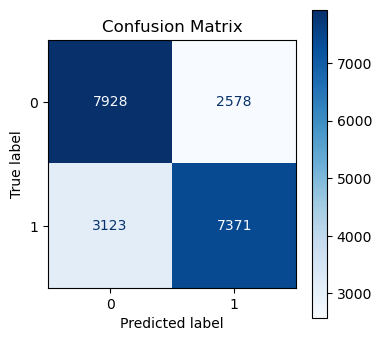

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=random_search.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [39]:
# Create and train a Gaussian Naive Bayes model for simple comparison
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = nb_model.predict(X_test)

# Calculate accuracy and F1 score
accuracy_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

# Print accuracy and F1 score
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(f"Naive Bayes F1 Score: {f1_nb:.4f}")

Naive Bayes Accuracy: 0.5867
Naive Bayes F1 Score: 0.4090
